<a href="https://colab.research.google.com/github/nadireus/Machine-Learning/blob/main/health_insurance_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



##Understanding the data
Age: insurance contractor age, years

Sex: insurance contractor gender, [female, male]

BMI: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

Children: number of children covered by health insurance / Number of dependents

Smoker: smoking, [yes, no]

Region: the beneficiary’s residential area in the US, [northeast, southeast, southwest, northwest]

Charges: Individual medical costs billed by health insurance, $ #predicted value
```



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling as pp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor


from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, log_loss, recall_score,accuracy_score,precision_score,f1_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.cluster import KElbowVisualizer
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [6]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/health_train.csv')

In [7]:
df_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/health_test.csv')

##Exploratory Data Analysis and Visualization

In [ ]:
df.head()

,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2500 non-null   float64
 1   sex       2500 non-null   object 
 2   bmi       2500 non-null   float64
 3   smoker    2500 non-null   object 
 4   region    2500 non-null   object 
 5   children  2500 non-null   int64  
 6   charges   2500 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 136.8+ KB


In [ ]:
df_test


,age,sex,bmi,smoker,region,children
0,39.296556,male,29.978109,no,northwest,4
1,40.367560,female,27.927669,no,southeast,5
2,32.881563,male,41.576865,no,southwest,5
3,62.000000,female,30.495000,no,northwest,2
4,32.476173,male,30.322774,yes,northeast,4
...,...,...,...,...,...,...
446,43.000000,male,35.531966,yes,southeast,2
447,31.374148,male,28.278549,no,northeast,4
448,50.370750,female,26.766297,no,northwest,4
449,49.201678,female,31.396840,no,northwest,4


##EDA for train data

In [8]:
#select numeric columns
df_numeric = df.select_dtypes(include=[np.number]) #select numeric columns
numeric_cols = df_numeric.columns.values 
print(numeric_cols)

['age' 'bmi' 'children' 'charges']


In [ ]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.146113,-0.055525,0.312723
bmi,0.146113,1.000000,-0.034233,0.197721
children,-0.055525,-0.034233,1.000000,-0.064515
charges,0.312723,0.197721,-0.064515,1.000000


In [9]:
#select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number]) 
non_numeric_cols = df_non_numeric.columns.values 
print(non_numeric_cols)

['sex' 'smoker' 'region']


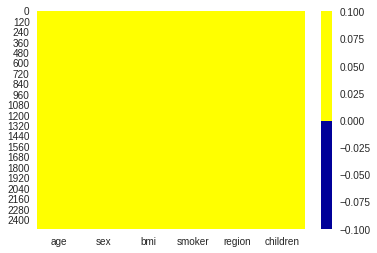

In [10]:
cols = df.columns[:6] # first 30 columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is not missing. blue is  missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [ ]:
df.isnull().sum()

age         0
sex         0
bmi         0
smoker      0
region      0
children    0
charges     0
dtype: int64

Data distribution analysys


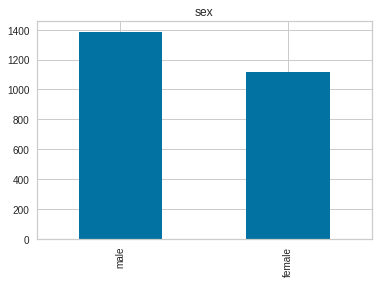

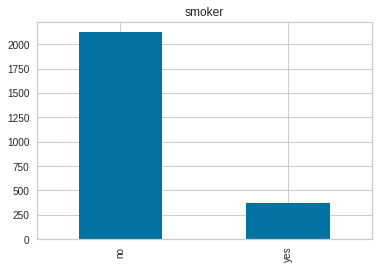

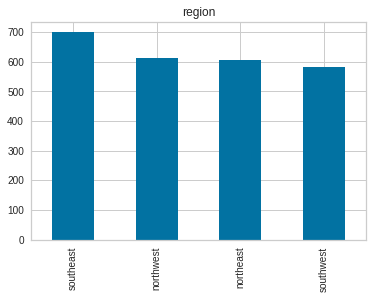

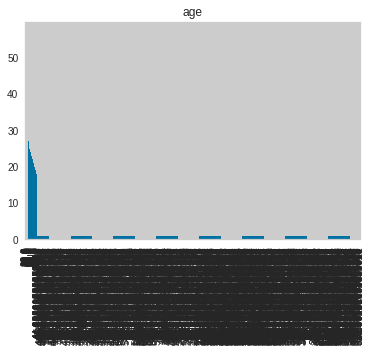

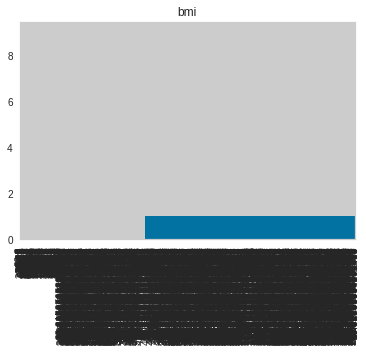

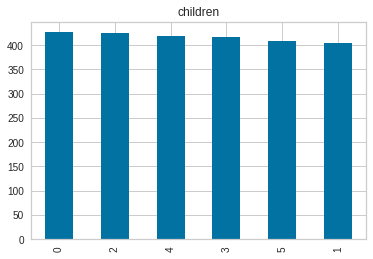

In [11]:
print('Data distribution analysys')
variables = ['sex','smoker','region','age','bmi','children']
for v in variables:
    df = df.sort_values(by=[v])
    df[v].value_counts().plot(kind = 'bar')
    plt.title(v)
    plt.show()

Variables pairplot:


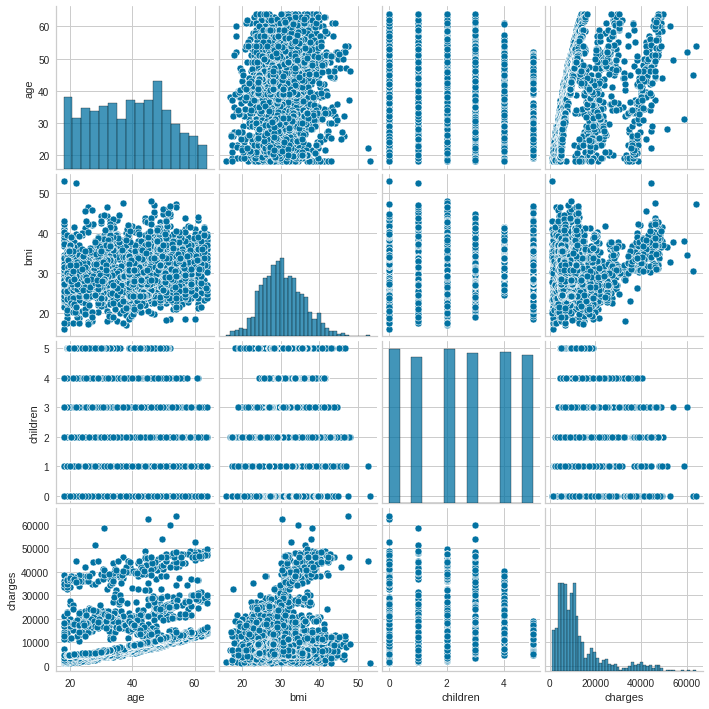

In [12]:
#variables pairplot
print('Variables pairplot:')
variables = ['sex','smoker','region','age','bmi','children','charges']
sns_plot = sns.pairplot(df[variables])
plt.show()

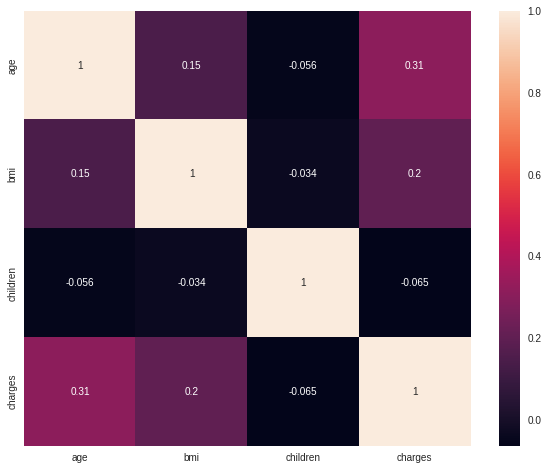

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)

In [13]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [14]:
from collections import Counter

In [15]:
df_numeric = df.select_dtypes(include=[np.number]) #select numeric columns
numericVar = df_numeric.columns.values

In [16]:
df.drop(detect_outliers(df,numericVar), inplace=True)

In [17]:
df_numeric2 = df_test.select_dtypes(include=[np.number]) #select numeric columns
numericVar = df_numeric2.columns.values

In [18]:
df_test.drop(detect_outliers(df_test,numericVar), inplace=True)

In [ ]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,2500.0,39.003033,12.264536,18.0000,28.845667,39.350208,48.688741,64.00000
bmi,2500.0,30.575497,5.390169,15.9600,26.717647,30.200000,34.046166,53.13000
children,2500.0,2.488400,1.707346,0.0000,1.000000,2.000000,4.000000,5.00000
charges,2500.0,12679.311518,10593.270485,1121.8739,5612.780878,9455.047274,14440.628060,63770.42801


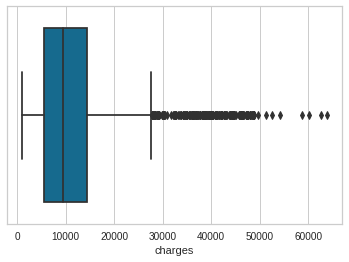

In [ ]:
sns.boxplot(df.charges);

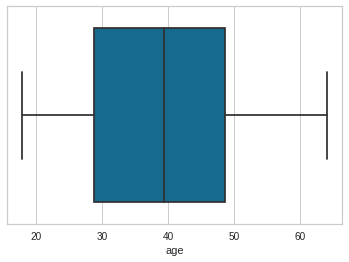

In [ ]:
sns.boxplot(df.age);

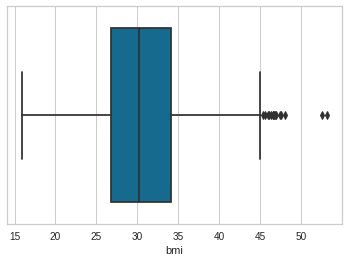

In [ ]:
sns.boxplot(df.bmi);#bmi>40 are severe obese

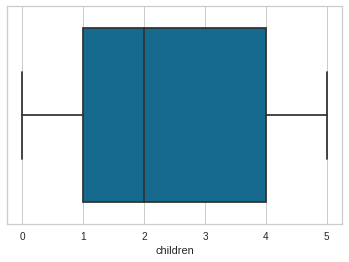

In [ ]:
sns.boxplot(df.children);

In [19]:
df["bmi"]=df["bmi"].apply(lambda item: 1 if  item > 30 else 0) #cleanig the column irrelavant values,gettting the intended values
df["bmi"]# obese or not

2341    0
2221    0
1664    0
52      0
847     0
       ..
506     0
1633    1
1324    0
1631    1
669     0
Name: bmi, Length: 2500, dtype: int64

In [20]:
df_test["bmi"]=df_test["bmi"].apply(lambda item: 1 if  item > 30 else 0) #cleanig the column irrelavant values,gettting the intended values
df_test["bmi"]# obese or not

0      0
1      0
2      1
3      1
4      1
      ..
446    1
447    0
448    0
449    1
450    1
Name: bmi, Length: 451, dtype: int64

In [75]:
df_eda=df.to_csv('df_eda')

In [76]:
df_eda_test=df_test.to_csv('df_eda_test')

#Dummies

In [77]:
df=pd.get_dummies(df,drop_first=True)
df.T

,2341,2221,1664,52,847,738,710,229,2348,2273,737,153,921,1935,774,1954,1463,1723,69,384,2241,1556,1670,1578,1443,1152,244,1832,100,2340,1337,2007,320,1196,507,2288,1230,1903,1456,2158,...,1240,84,2005,1494,1409,1479,23,1553,1978,1183,2471,1051,1563,306,446,2458,1303,1278,1799,134,2165,757,1355,31,1683,1635,1932,509,960,2146,2381,1342,1016,1045,973,506,1633,1324,1631,669
age,18.000,19.000,37.000,57.000,55.000,24.000,55.000,36.000,62.000,49.000,24.000,62.000,19.000,36.000,18.000,18.000,18.000,54.000,20.000,48.000,37.000,40.000,56.000,22.000,22.000,53.000,32.000,60.000,20.000,57.000,19.000,21.000,58.000,61.000,19.000,31.000,27.000,18.000,24.000,48.000,...,45.000,31.000,42.000,40.000,25.000,31.000,29.000,47.000,49.000,24.000,41.000,45.000,20.000,26.000,40.000,45.000,20.000,28.000,20.000,44.000,40.000,31.000,30.000,43.000,41.000,46.000,44.000,45.000,44.000,20.000,21.000,20.000,43.000,43.000,30.000,43.000,49.000,42.000,25.000,21.000
bmi,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000
children,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000
charges,1694.796,1744.465,20420.605,27533.913,11286.539,18648.422,10214.636,4889.037,13457.961,8988.159,2850.684,13352.100,33307.551,5272.176,21344.847,2203.472,1131.507,10231.500,1769.532,7789.635,5028.147,5910.944,11658.379,2156.752,2250.835,9869.810,3866.855,12146.971,2257.475,27218.437,32548.340,1906.358,11842.442,29141.360,17352.680,3761.292,18246.496,7323.735,1977.815,21232.182,...,10431.965,6797.219,9321.861,8886.017,5368.551,6335.768,5795.906,10676.098,11552.904,5395.932,9074.245,9763.271,4822.796,5727.128,9143.628,13342.330,4809.795,5615.369,4809.452,9654.182,9046.371,6673.643,6572.669,9579.156,9080.345,13640.663,9619.670,10289.471,9595.440,4805.605,4921.737,4805.286,9335.022,9564.203,6069.861,9456.399,11555.687,13712.765,5535.877,4960.035
sex_male,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000
smoker_yes,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
region_northwest,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00

In [78]:
df_test=pd.get_dummies(df_test,drop_first=True)
df_test.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450
age,39.000,40.000,33.000,62.000,32.000,22.000,46.000,39.000,42.000,19.000,44.000,26.000,52.000,39.000,49.000,23.000,35.000,20.000,25.000,34.000,24.000,54.000,42.000,43.000,39.000,29.000,41.000,25.000,18.000,49.000,25.000,31.000,19.000,45.000,22.000,29.000,33.000,44.000,45.000,61.000,...,35.000,54.000,47.000,45.000,42.000,47.000,33.000,23.000,21.000,40.000,20.000,60.000,45.000,52.000,25.000,51.000,42.000,37.000,48.000,48.000,49.000,55.000,29.000,21.000,32.000,37.000,22.000,48.000,37.000,26.000,39.000,30.000,42.000,61.000,21.000,43.000,31.000,50.000,49.000,49.000
sex,1.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,1.000,...,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,1.000
bmi,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,...,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000
smoker,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,...,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000
region,1.000,2.000,3.000,1.000,0.000,0.000,1.000,2.000,2.000,1.000,2.000,2.000,0.000,0.000,1.000,0.000,2.000,3.000,1.000,3.000,3.000,3.000,0.000,2.000,2.000,1.000,3.000,1.000,0.000,1.000,3.000,2.000,3.000,2.000,2.000,3.000,0.000,1.000,2.000,3.000,...,3.000,1.000,2.000,2.000,3.000,2.000,0.000,3.000,2.000,2.000,2.000,0.000,0.000,0.000,3.000,0.000,0.000,1.000,1.000,1.000,1.000,3.000,2.000,3.000,0.000,3.000,0.000,1.000,2.000,3.000,2.000,2.000,2.000,1.000,2.000,2.000,0.000,1.000,1.000,3.000
children,4.000,5.000,5.000,2.000,4.000,5.000,3.000,5.000,5.000,0.000,5.000,1.000,1.000,3.000,3.000,5.000,4.000,5.000,0.000,2.000,3.000,1.000,1.000,3.000,5.000,3.000,5.000,0.000,0.000,2.000,5.000,2.000,5.000,5.000,2.000,5.000,2.000,2.000,5.000,1.000,...,3.000,3.000,2.000,2.000,4.000,2.000,3.000,5.000,0.000,5.000,4.000,0.000,3.000,2.000,3.000,3.000,4.000,2.000,4.000,4.000,4.000,4.000,1.000,0.000,4.000,2.000,5.000,4.000,0.000,5.000,2.000,3.000,3.000,1.000,0.000,2.000,4.000,4.000,4.000,0.000


##Preprocessing

In [79]:
X=df.drop(["charges"], axis=1)
y=df["charges"]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

In [81]:
scaler =MinMaxScaler()

In [82]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

robust scaler

#Linear Regression

In [83]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

In [84]:
lm.fit(X_train_scaled, y_train)

LinearRegression()

In [85]:
y_pred = lm.predict(X_test_scaled)
y_train_pred = lm.predict(X_train_scaled)

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_val(y_train, y_train_pred, y_test, y_pred, i):
    
    scores = {i+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    i+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [87]:
pd.options.display.float_format = '{:.3f}'.format

In [88]:
ls =train_val(y_train, y_train_pred, y_test, y_pred, "linear")
ls

,linear_train,linear_test
R2,0.722,0.688
mae,3741.307,3937.357
mse,30647173.929,36369759.157
rmse,5535.989,6030.735


crossvalidate

In [89]:
from sklearn.model_selection import cross_validate, cross_val_score

In [90]:
model = LinearRegression()
lineer_reg_scores = cross_validate(model, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 5)

In [91]:
lineer_reg_scores = pd.DataFrame(lineer_reg_scores, index=range(1,6))
lineer_reg_scores.iloc[:, 2:].mean()

test_r2                                    0.719
test_neg_mean_absolute_error           -3759.316
test_neg_mean_squared_error        -30956417.995
test_neg_root_mean_squared_error       -5552.900
dtype: float64

In [92]:
train_val(y_train, y_train_pred, y_test, y_pred, "linear")

,linear_train,linear_test
R2,0.722,0.688
mae,3741.307,3937.357
mse,30647173.929,36369759.157
rmse,5535.989,6030.735


#K-fold validation

In [93]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score, KFold
from sklearn import model_selection
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [94]:
cols_not_reg3=non_numeric_cols

In [ ]:
X=df.drop(["charges"], axis=1)
y=df["charges"]

In [97]:
kf=KFold(n_splits=200, random_state=101, shuffle=True)
intercepts=[]
mses=[]
coefs=[]

for train_index, test_index in kf.split(X):
    
    lr=linear_model.LinearRegression()
    lr.fit(X.iloc[train_index],df["charges"].iloc[train_index])
    lr_predictions=lr.predict(X.iloc[test_index])
    
    lr_mse=mean_squared_error(df["charges"].iloc[test_index],lr_predictions)

In [98]:
 lr_mse

23392725.784544453

###Ridge

In [99]:
from sklearn.linear_model import Ridge

In [100]:
from sklearn.model_selection import GridSearchCV

In [101]:
ridge= Ridge( random_state=42, max_iter= 200000)

In [102]:
param_grid = {"alpha":[0.01, 0.012, 0.2, 0.5, 0.6, 0.7, 1],
            }

In [103]:
grid_model = GridSearchCV(estimator = ridge, param_grid = param_grid, scoring = 'neg_root_mean_squared_error',
                         cv =5, verbose =2)

In [104]:
grid_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ........................................alpha=0.012; total time=   0.0s
[CV] END ........................................alpha=0.012; total time=   0.0s
[CV] END ........................................alpha=0.012; total time=   0.0s
[CV] END ........................................alpha=0.012; total time=   0.0s
[CV] END ........................................alpha=0.012; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ........................................

GridSearchCV(cv=5, estimator=Ridge(max_iter=200000, random_state=42),
             param_grid={'alpha': [0.01, 0.012, 0.2, 0.5, 0.6, 0.7, 1]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [105]:
grid_model.best_params_

{'alpha': 0.2}

##For Ridge Regression CV with alpha : 0.2

In [106]:
model = Ridge(alpha=0.2, random_state=42)
ridge_scores = cross_validate(model, X_train_scaled, y_train,
                    scoring=['r2', 'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv=5)

In [107]:
ridge_scores = pd.DataFrame(ridge_scores, index = range(1, 6))
ridge_scores.iloc[:,2:].mean()

test_r2                                    0.719
test_neg_mean_absolute_error           -3760.100
test_neg_mean_squared_error        -30955822.128
test_neg_root_mean_squared_error       -5552.891
dtype: float64

In [108]:
y_pred = grid_model.predict(X_test_scaled)
y_train_pred = grid_model.predict(X_train_scaled)

In [109]:
train_val(y_train, y_train_pred, y_test, y_pred, "ridge")

,ridge_train,ridge_test
R2,0.722,0.688
mae,3741.993,3938.513
mse,30647251.702,36376465.201
rmse,5535.996,6031.291


##LASSO

In [110]:
from sklearn.linear_model import Lasso, LassoCV

In [111]:
lasso_model = Lasso(alpha=0.0001, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.0001, random_state=42)

In [112]:
y_pred = lasso_model.predict(X_test_scaled)
y_train_pred = lasso_model.predict(X_train_scaled)

In [114]:
lss = train_val(y_train, y_train_pred, y_test, y_pred, "lasso_model")
lss

,lasso_model_train,lasso_model_test
R2,0.722,0.688
mae,3741.307,3937.357
mse,30647173.929,36369759.233
rmse,5535.989,6030.735


##GridSearch for Lasso

In [115]:
from sklearn.model_selection import GridSearchCV

In [116]:
alphas= np.logspace(-4,5,30)

In [117]:
lasso_model = Lasso(alpha=alphas, random_state=42)

In [118]:
tuned_parameters= {'alpha':alphas}
n_folds=5

In [119]:
clf=GridSearchCV(estimator=lasso_model , param_grid=tuned_parameters, cv=n_folds, scoring="neg_mean_squared_error", refit=True)

In [120]:
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Lasso(alpha=array([1.00000000e-04, 2.04335972e-04, 4.17531894e-04, 8.53167852e-04,
       1.74332882e-03, 3.56224789e-03, 7.27895384e-03, 1.48735211e-02,
       3.03919538e-02, 6.21016942e-02, 1.26896100e-01, 2.59294380e-01,
       5.29831691e-01, 1.08263673e+00, 2.21221629e+00, 4.52035366e+00,
       9.23670857e+00, 1.88739182e+01, 3.85662042e+01, 7.88046282e+01,
       1.6...
       3.03919538e-02, 6.21016942e-02, 1.26896100e-01, 2.59294380e-01,
       5.29831691e-01, 1.08263673e+00, 2.21221629e+00, 4.52035366e+00,
       9.23670857e+00, 1.88739182e+01, 3.85662042e+01, 7.88046282e+01,
       1.61026203e+02, 3.29034456e+02, 6.72335754e+02, 1.37382380e+03,
       2.80721620e+03, 5.73615251e+03, 1.17210230e+04, 2.39502662e+04,
       4.89390092e+04, 1.00000000e+05])},
             scoring='neg_mean_squared_error')

In [121]:
lasso_model=clf.best_estimator_
print("  best Estimator: ", lasso_model)

  best Estimator:  Lasso(alpha=1.0826367338740541, random_state=42)


In [122]:
y_pred=clf.predict(X_test_scaled)
mse=mean_squared_error(y_test, y_pred)

In [123]:
#y_pred = lasso_model.predict(X_test_scaled)
y_train_pred = clf.predict(X_train_scaled)

In [124]:
lss1 = train_val(y_train, y_train_pred, y_test, y_pred, "lasso_clf")
lss1

,lasso_clf_train,lasso_clf_test
R2,0.722,0.688
mae,3740.760,3936.940
mse,30647278.153,36370650.631
rmse,5535.998,6030.808


##Feature importances with Ridge

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 100)

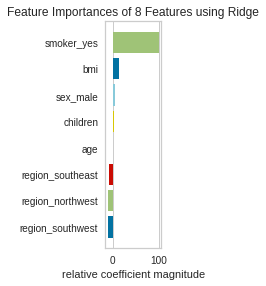

In [126]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(ridge, labels=pd.DataFrame(X_train).columns)
visualizer = RadViz(size=(72, 300))
viz.fit(X_train, y_train)
viz.show()

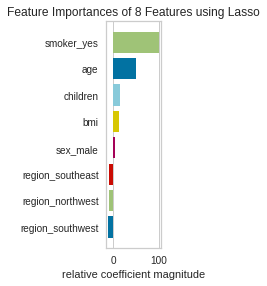

In [127]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(lasso_model, labels=pd.DataFrame(X_train).columns)
visualizer = RadViz(size=(72, 300))
viz.fit(X_train, y_train)
viz.show()

#Logic Regression

In [128]:
pip install pyforest

  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14607 sha256=e7bb4f6e381634077bb20e17ba784c649e9275868ae5f26c689c30a801625287
  Stored in directory: /root/.cache/pip/wheels/61/1c/da/48e6c884142d485475d852d69d20a096aba5beceb338822893
Successfully built pyforest


In [129]:
import pyforest
import plotly
import cufflinks as cf
#Enabling the offline mode for interactive plotting locally
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()
#To display the plots
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.preprocessing import OrdinalEncoder

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
seed=5

In [146]:
df2=df.copy()

In [147]:
df2.charges

2341    1694.796
2221    1744.465
1664   20420.605
52     27533.913
847    11286.539
          ...   
506     9456.399
1633   11555.687
1324   13712.765
1631    5535.877
669     4960.035
Name: charges, Length: 2500, dtype: float64

In [148]:

def map_age(column):
    mapped=[]
    for row in column:
        if row < 5000:
          mapped.append('low')
        elif 5000 <row< 10000:
          mapped.append('middle')
        else:
          mapped.append('higher')
    return mapped
df2["charges"]=map_age(df2["charges"])

In [149]:
df2["charges"].value_counts()

higher    1168
middle     848
low        484
Name: charges, dtype: int64

In [150]:
Xlog=df2.drop(["charges"], axis=1)
ylog=df2["charges"]

In [154]:
X_train, X_test, y_train, y_test = train_test_split(Xlog,ylog, test_size=0.30, random_state=5)

In [161]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [151]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [160]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()

penalty = [ "l2"]
C = np.logspace(-1, 5, 20)
class_weight= ["balanced", None] 
# The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies 
# in the input data
solver = ["lbfgs", "liblinear", "sag", "saga"]

param_grid = {"penalty" : penalty,
              "C" : C,
              "class_weight":class_weight,
              "solver":solver}


log_grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=10,
                          scoring = "recall",   #f1_0 = make_scorer(f1_score, pos_label =0)
                          n_jobs = -1)

In [159]:
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()



In [157]:
log_grid_model.fit(X_train_scaled,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 2.06913808e-01, 4.28133240e-01, 8.85866790e-01,
       1.83298071e+00, 3.79269019e+00, 7.84759970e+00, 1.62377674e+01,
       3.35981829e+01, 6.95192796e+01, 1.43844989e+02, 2.97635144e+02,
       6.15848211e+02, 1.27427499e+03, 2.63665090e+03, 5.45559478e+03,
       1.12883789e+04, 2.33572147e+04, 4.83293024e+04, 1.00000000e+05]),
                         'class_weight': ['balanced', None], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga']},
             scoring='recall')

In [ ]:
y_pred = log_grid_model(X_test_scaled)
y_train_pred = log_grid_model(X_train_scaled)

In [ ]:
log =train_val(y_train, y_train_pred, y_test, y_pred, "logistic")
log

In [167]:
#Import libraries for data transformations

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [170]:
X = Xlog

Y = ylog

In [171]:
Y

2341       low
2221       low
1664    higher
52      higher
847     higher
         ...  
506     middle
1633    higher
1324    higher
1631    middle
669        low
Name: charges, Length: 2500, dtype: object

In [172]:
#get the number of rows and columns
r, c = df2.shape

#get the list of columns
cols = df2.columns
#create an array which has indexes of columns
i_cols = []
for i in range(0,c-1):
    i_cols.append(i)
#array of importance rank of all features  
ranks = []



#Y is the target column, X has the rest
X = Xlog

Y = ylog

#Validation chunk size
val_size = 0.1

#Use a common seed in all experiments so that same chunk is used for validation
seed = 0

#Split the data into chunks
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.33,stratify=Y ,random_state = seed)



#All features
X_all = []
#Additionally we will make a list of subsets
X_all_add =[]

#columns to be dropped
rem = []
#indexes of columns to be dropped
i_rem = []

#List of combinations
comb = []
comb.append("All+1.0")

#Add this version of X to the list 
X_all.append(['Orig','All', X_train,X_val,1.0,cols[:c-1],rem,ranks,i_cols,i_rem])

#point where categorical data begins
size=10

#Standardized
#Apply transform only for non-categorical data
X_temp = StandardScaler().fit_transform(X_train.iloc[:,0:size])
X_val_temp = StandardScaler().fit_transform(X_val.iloc[:,0:size])
#Concatenate non-categorical data and categorical
X_con = np.concatenate((X_temp,X_train.iloc[:,size:]),axis=1)
X_val_con = np.concatenate((X_val_temp,X_val.iloc[:,size:]),axis=1)
#Add this version of X to the list 
X_all.append(['StdSca','All', X_con,X_val_con,1.0,cols,rem,ranks,i_cols,i_rem])

#MinMax
#Apply transform only for non-categorical data
X_temp = MinMaxScaler().fit_transform(X_train.iloc[:,0:size])
X_val_temp = MinMaxScaler().fit_transform(X_val.iloc[:,0:size])
#Concatenate non-categorical data and categorical
X_con = np.concatenate((X_temp,X_train.iloc[:,size:]),axis=1)
X_val_con = np.concatenate((X_val_temp,X_val.iloc[:,size:]),axis=1)
#Add this version of X to the list 
X_all.append(['MinMax', 'All', X_con,X_val_con,1.0,cols,rem,ranks,i_cols,i_rem])

#Normalize
#Apply transform only for non-categorical data
X_temp = Normalizer().fit_transform(X_train.iloc[:,0:size])
X_val_temp = Normalizer().fit_transform(X_val.iloc[:,0:size])
#Concatenate non-categorical data and categorical
X_con = np.concatenate((X_temp,X_train.iloc[:,size:]),axis=1)
X_val_con = np.concatenate((X_val_temp,X_val.iloc[:,size:]),axis=1)
#Add this version of X to the list 
X_all.append(['Norm', 'All', X_con,X_val_con,1.0,cols,rem,ranks,i_cols,i_rem])

#Impute
#Imputer is not used as no data is missing

#List of transformations
trans_list = []

for trans,name,X,X_val,v,cols_list,rem_list,rank_list,i_cols_list,i_rem_list in X_all:
    trans_list.append(trans)

#Extra tree classifier

In [184]:
from sklearn.ensemble import ExtraTreesClassifier

n_list = [100]
 
for n_estimators in n_list:
    #Set the base model
    model = ExtraTreesClassifier(n_jobs=-1,n_estimators=n_estimators, random_state=seed)
   
    algo = "ET"

    #Set figure size
    plt.rc("figure", figsize=(20, 10))

    #Accuracy of the model using all features
model.fit(X_train,Y_train)
result = model.score(X_val,Y_val)

print(trans+"+"+name+"+%d" % (v*(c-1)))
print(result)
comb.append("%s with n=%s+%s of %s" % (algo,n_estimators,"All",1.0))

   
    

Orig+All+8
0.9115151515151515


In [185]:
y_pred = lm.predict(X_val)
y_train_pred = lm.predict(X_train)

In [ ]:
etr =train_val(Y_train, y_train_pred, Y_val, y_pred, "extra tree")
etr

#Random Forest

In [39]:
seed=5

In [23]:
Xrf=df.drop(["charges"], axis=1)
yrf=df["charges"]

In [24]:
catagoricals = Xrf.select_dtypes("object").columns
catagoricals


Index(['sex', 'smoker', 'region'], dtype='object')

In [26]:
from sklearn.preprocessing import OrdinalEncoder

In [30]:
df.age=round(df.age)

In [32]:
enc = OrdinalEncoder()
Xrf[catagoricals] = enc.fit_transform(Xrf[catagoricals])
Xrf.head()

,age,sex,bmi,smoker,region,children
2341,18.0,1.0,0,0.0,0.0,0
2221,19.0,0.0,0,0.0,3.0,0
1664,37.0,1.0,0,0.0,3.0,0
52,57.0,0.0,0,1.0,2.0,0
847,55.0,0.0,0,0.0,0.0,0


In [188]:
encoded_df=Xrf.to_csv('encoded_df')

In [33]:
catagoricals_test = df_test.select_dtypes("object").columns
catagoricals_test


Index(['sex', 'smoker', 'region'], dtype='object')

In [34]:
df_test.age=round(df_test.age)

In [35]:
X_datatest=df_test

In [36]:
enc = OrdinalEncoder()
X_datatest[catagoricals_test] = enc.fit_transform(X_datatest[catagoricals_test])
X_datatest.head()

,age,sex,bmi,smoker,region,children
0,39.0,1.0,0,0.0,1.0,4
1,40.0,0.0,0,0.0,2.0,5
2,33.0,1.0,1,0.0,3.0,5
3,62.0,0.0,1,0.0,1.0,2
4,32.0,1.0,1,1.0,0.0,4


In [189]:
encoded_test=X_datatest.to_csv('encoded_test')

In [40]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(Xrf, yrf, test_size=1/3, random_state=5)

In [41]:
rf_model = RandomForestRegressor( random_state=seed)
rf_model.fit(X_train2, y_train2)

RandomForestRegressor(random_state=5)

In [42]:
y_pred2 = rf_model.predict(X_test2)
y_train_pred2 = rf_model.predict(X_train2)

In [49]:
train_val(y_train2, y_train_pred2, y_test2, y_pred2, "rf_model")

,linear_train,linear_test
R2,0.972,0.828
mae,766.655,2088.411
mse,3118467.528,19966402.783
rmse,1765.918,4468.378


#Random Forest with Grid Search

In [50]:
param_grid = {'n_estimators':[32,64],
             'max_depth':[3,5,16], 'max_leaf_nodes':[5,14,16],'min_samples_split':[18,20,22] } #
             

In [51]:
rf_model = RandomForestRegressor( random_state=seed,)
rf_grid_model = GridSearchCV(rf_model,
                             param_grid,
                             verbose=3,
                             n_jobs=-1)

In [52]:
rf_grid_model.fit(X_train2,y_train2)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=RandomForestRegressor(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 16], 'max_leaf_nodes': [5, 14, 16],
                         'min_samples_split': [18, 20, 22],
                         'n_estimators': [32, 64]},
             verbose=3)

In [53]:
rf_grid_model.best_params_

{'max_depth': 16,
 'max_leaf_nodes': 16,
 'min_samples_split': 18,
 'n_estimators': 32}

In [54]:
rf_grid_model.best_score_

0.8623520986283003

In [55]:
y_pred2 = rf_grid_model.predict(X_test2)
y_train_pred2 = rf_grid_model.predict(X_train2)

In [56]:
train_val(y_train2, y_train_pred2, y_test2, y_pred2, "rf_grid_model")

,rf_grid_model_train,rf_grid_model_test
R2,0.877,0.830
mae,1928.575,2332.613
mse,13517923.624,19682676.197
rmse,3676.673,4436.516


#XGBoost

In [57]:

xgb_model = XGBRegressor(random_state=seed)

In [58]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train2)
classes_weights

array([1., 1., 1., ..., 1., 1., 1.])

In [59]:
xgb_model.fit(X_train2,y_train2, sample_weight=classes_weights)

[20:53:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=5)

In [60]:
y_pred2 = xgb_model.predict(X_test2)
y_train_pred2 = xgb_model.predict(X_train2)

In [61]:
train_val(y_train2, y_train_pred2, y_test2, y_pred2, "xgb_model")

,xgb_model_train,xgb_model_test
R2,0.889,0.833
mae,1831.080,2297.195
mse,12292983.761,19372289.894
rmse,3506.135,4401.396


#XGBoost Model GridsearchCV

In [62]:
comp = pd.DataFrame(classes_weights)

comp["label"]= y_train2.reset_index(drop=True)
comp.groupby("label")[0].value_counts()

label      0    
1121.874   1.000    1
1131.507   1.000    1
1135.941   1.000    1
1136.399   1.000    1
1137.470   1.000    1
                   ..
48885.243  1.000    1
52590.829  1.000    1
54108.419  1.000    1
58571.074  1.000    1
60021.399  1.000    1
Name: 0, Length: 1666, dtype: int64

In [63]:
param_grid = {"n_estimators":[32, 48, 64],
              'max_depth':[3,5,6],
              "learning_rate": [0.01,0.05, 0.1],
              "subsample":[ 1,2],
              "colsample_bytree":[ 1, 2]}

In [64]:
xgb_model = XGBRegressor(random_state=seed)
xgb_grid_model = GridSearchCV(xgb_model, 
                              param_grid, 
                               
                              n_jobs = -1, 
                              verbose = 2).fit(X_train2, y_train2,sample_weight=classes_weights)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[20:53:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
xgb_grid_model.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 48,
 'subsample': 1}

In [66]:
xgb_grid_model.best_score_

0.8652024079312666

In [67]:
y_pred2 = xgb_grid_model.predict(X_test2)
y_train_pred2 = xgb_grid_model.predict(X_train2)

In [68]:
train_val(y_train2, y_train_pred2, y_test2, y_pred2, "xgb_grid_model")

,xgb_grid_model_train,xgb_grid_model_test
R2,0.913,0.842
mae,1495.440,2112.300
mse,9615356.839,18360032.384
rmse,3100.864,4284.861


#tunned parameters

In [ ]:
xgb_grid_model.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 48,
 'subsample': 1}

In [ ]:
xgb_grid_model.best_score_

0.8652024079312666

In [ ]:
y_pred2 = xgb_grid_model.predict(X_test2)
y_train_pred2 = xgb_grid_model.predict(X_train2)

In [ ]:
train_val(y_train2, y_train_pred2, y_test2, y_pred2, "xgb_grid_model")

,xgb_grid_model_train,xgb_grid_model_test
R2,0.913,0.842
mae,1495.440,2112.300
mse,9615356.839,18360032.384
rmse,3100.864,4284.861


 SVC
Vanilla SVC model

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [ ]:
operations_svc = [("scaler", MinMaxScaler()), ("svc", LinearSVR(random_state=seed))]
pipe_svc_model = Pipeline(steps=operations_svc)

In [ ]:
pipe_svc_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svc', LinearSVR(random_state=2))])

In [ ]:
y_pred2 = pipe_svc_model.predict(X_test)
y_train_pred2 = pipe_svc_model.predict(X_train)

In [ ]:
train_val(y_train2, y_train_pred2, y_test2, y_pred2, "pipe_svc_model")

,pipe_svc_model_train,pipe_svc_model_test
R2,-0.724,-0.742
mae,9231.376,9563.489
mse,190124359.193,201899132.559
rmse,13788.559,14209.121


#final model without pickle

In [ ]:
enc = OrdinalEncoder()
Xrf[catagoricals] = enc.fit_transform(Xrf[catagoricals])
Xrf.head()

In [70]:
final_model = xgb_grid_model.fit(Xrf, yrf)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[21:02:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [71]:
predictions = final_model.predict(X_datatest)

In [72]:
submission=pd.DataFrame(predictions)

In [73]:
submission

,0
0,9642.262
1,9770.997
2,6413.160
3,16460.877
4,34337.863
...,...
446,39933.996
447,16943.039
448,11673.938
449,11320.485
